<a href="https://colab.research.google.com/github/mango766/ml_learning/blob/main/02%E6%89%8B%E5%86%99%E6%95%B0%E5%AD%97%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**手写数字分类任务**

准备

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1、获取数据 MNIST

sklearn库提供了助手功能用来下载数据集。

**注意**：从 Scikit-Learn 0.24 开始，fetch_openml() 默认返回 Pandas DataFrame。为了避免这种情况并保持与书中相同的代码，我们使用 as_frame=False。

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

查看数组

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

共有70000张图片，每张图片有28*28=784个特征点（像素），从0到255

随机抓取一个对象，使用imshow（）函数将其展现出来

Saving figure some_digit_plot


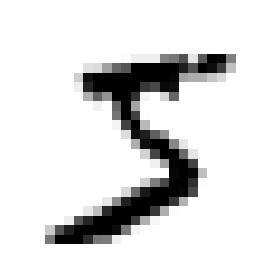

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
y[0]

'5'

将y转换为整数,方便操作

In [9]:
y = y.astype(np.uint8)

In [10]:
y[0]

5

In [81]:
def plot_digit(data):#显示单幅图像
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [70]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

创建测试集，实际上，mnist数据集已经分成训练集（前6万张）与测试集（最后1万张）

**X[:60000] 从开始到第60000个, X[60000:] 从第60001个到结束, y[:60000], y[6000:]**

In [104]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#X[:60000] 从开始到第60000个, X[60000:] 从第60001个到结束, y[:60000], y[6000:]


# 2、训练二元分类器

创建目标向量,以数字5作为例子

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note:**在 Scikit-Learn 的**未来版本**中，一些超参数将具有不同的**默认值**，例如 max_iter 和 tol。为了面向未来，我们明确地将这些超参数设置为它们未来的默认值。

使用随机梯度训练下降训练器（SGD）

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

测试一下

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# 3、性能评估

## 3.1 使用交叉验证

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

设置一个都判定为非5的分类器

In [16]:
from sklearn.base import BaseEstimator

class  Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)


In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

发现准确率都超过了90%，这是因为5的图片只占了10%。

所以，**准确率**通常无法成为**首要性能指标**，尤其当**有偏数据集**时（某些类比其他类更为频繁）。

## 3.2 混淆矩阵

评估分类器性能的更好指标是**混淆矩阵**，其总体思路是统计A类别被分成B类别的次数。

通过查看混淆矩阵的第5行3列，可以看到将数字3与数字5混淆的次数。

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)#将预测值与目标值进行对比

array([[53892,   687],
       [ 1891,  3530]])

行代表实际类别，列代表预测类别

------**非5**-----**5**

**非5**

**5** 

该矩阵代表有

（左上角）个数的图被**正确**地分成了**非5（真负类）**，

（右上角）个数的图被**错误**地分成了**5（假正类）**，

（左下角）个数的图被**错误**地分成了**非5（假负类）**，

（右下角）个数的图被**正确**地分为了**5（真正类）**。



Tips：

**假正类：误判**

**假负类：漏判**

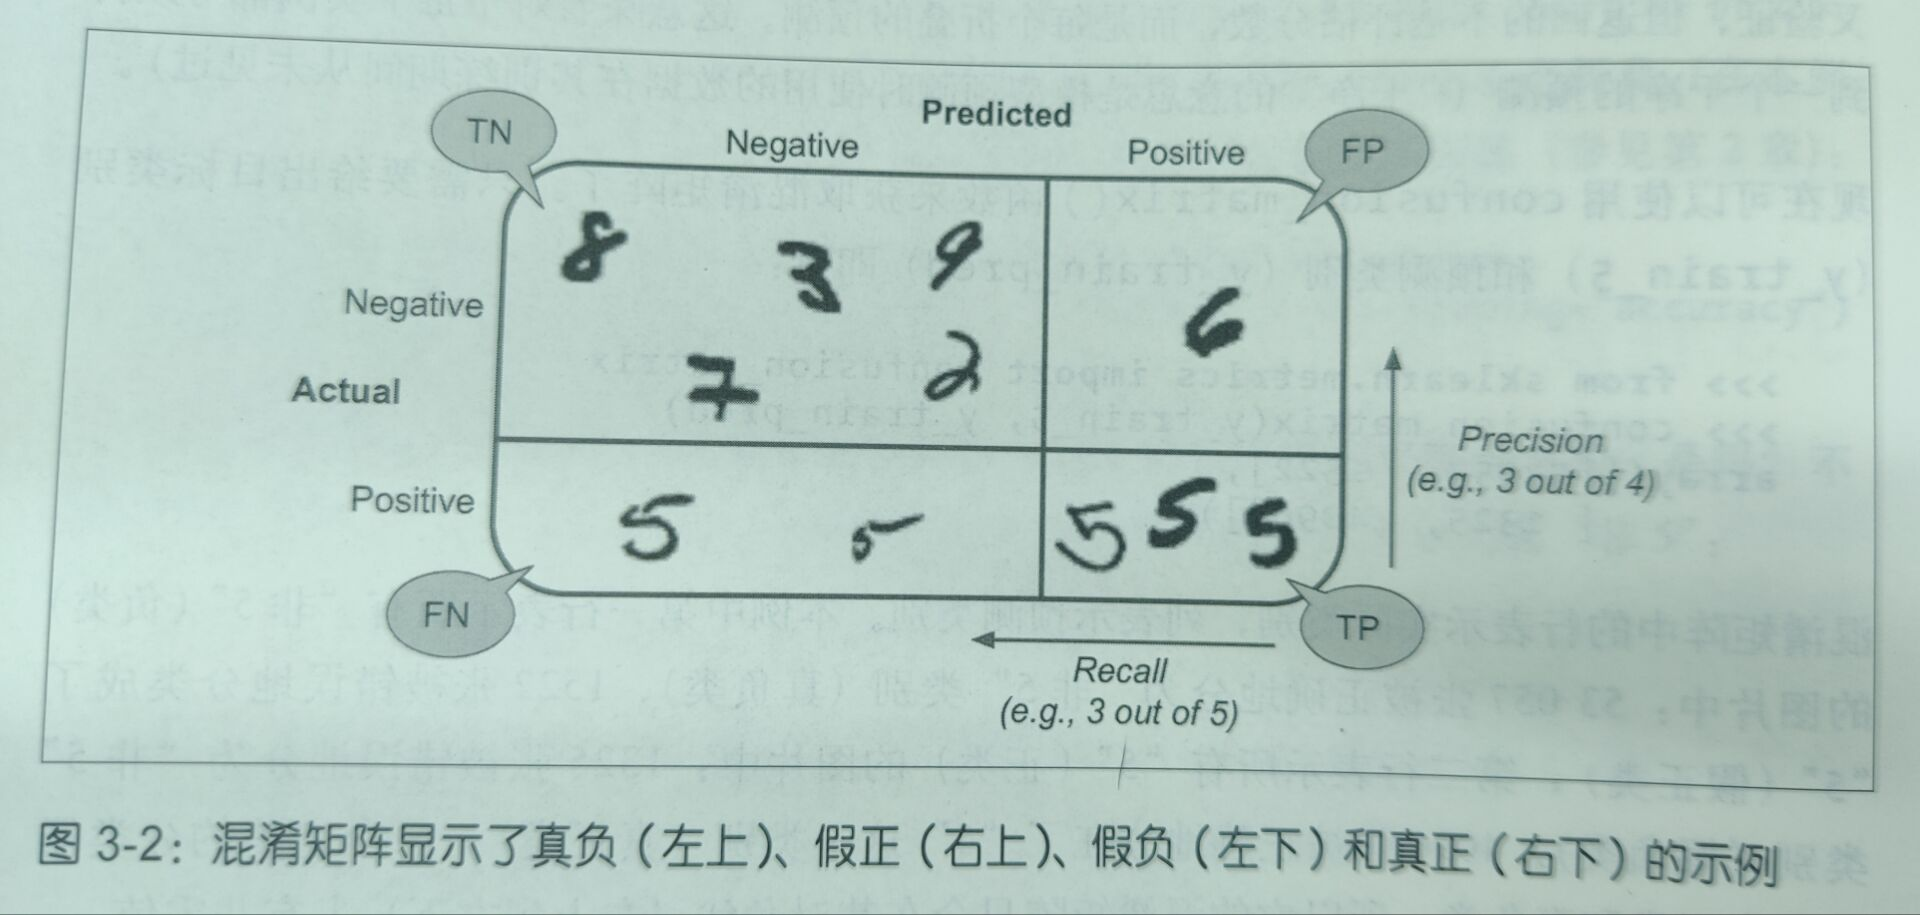

## 3.3 精度与召回率

In [20]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))#精度

print(recall_score(y_train_5, y_train_pred))#召回率

0.8370879772350012
0.6511713705958311


F1分数：精度与召回率的谐波平均值

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.4 精度/召回率权衡

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0#阈值设为0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000#阈值设为8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

返回所有预测结果的决策分数(得出阈值大概的范围),得出在所有阈值情况下，所有的精度与召回率。

In [25]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

绘制函数图

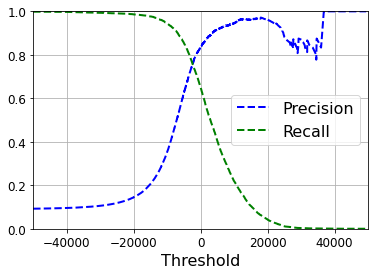

In [27]:
def plot_precision_recalll_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1],'b--',label='Precision',linewidth=2)
  plt.plot(thresholds, recalls[:-1],'g--',label='Recall',linewidth=2)
  plt.legend(loc="center right", fontsize=16) # Not shown in the book
  plt.xlabel("Threshold", fontsize=16)        # Not shown
  plt.grid(True)                              # Not shown
  plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recalll_vs_threshold(precisions, recalls, thresholds)
plt.show()

设置能提供90%的最低阈值

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

使用阈值进行预测

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.5 ROC曲线

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

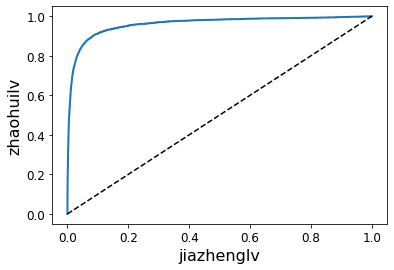

In [33]:
def plot_roc_curve(fpr,tpr, label=None):
  plt.plot(fpr,tpr,linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.xlabel("jiazhenglv", fontsize=16)
  plt.ylabel("zhaohuilv", fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

召回率越高，分类器产生的假正类就越多，优秀的分类器应该靠向左上角。

有一种比较分类器性能的方法是测量曲线下面积（AUC）,完美的分类器AUC等于0.5

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

训练随机树分类器模型

In [35]:
from  sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')


In [36]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

绘制roc曲线

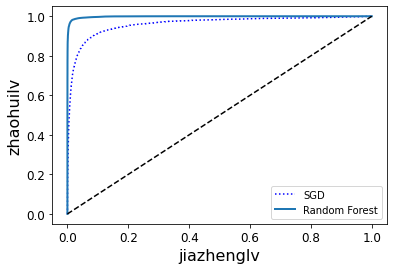

In [37]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest,'Random Forest')
plt.legend(loc='lower right')
plt.show()

由此可见，随机数分类器优于SGD分类器，因为他的roc曲线更靠近左上角，并且auc更接近于0.5


In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 4、多类分类器

OvO：一对一分类；0-1， 0-2，。。。

OvR：一对多；0-分类，1-分类，。。。

**svm**分类

在内部，训练了45个二元分类器，获得对图片的决策分数，然后选择分数最高的类。

In [39]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

发现5的分数最高。

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

OvR策略

In [52]:
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# ovr_clf.predict([some_digit])
# 用时较长

array([5], dtype=uint8)

In [53]:
# len(ovr_clf.estimators_)

10

用SGD训练同样简单，检测错误

In [60]:
# sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

将数据简单缩放后准确率提高

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 5、误差分析

查看混淆矩阵

In [62]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train, cv = 3)#交叉验证
conf_mx = confusion_matrix(y_train, y_train_pred)#对比
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

绘图显示

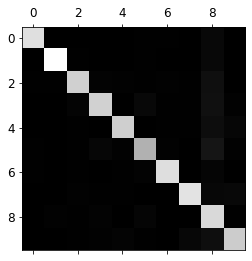

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [65]:
row_sums = conf_mx.sum(axis =1,keepdims=True)
norm_conf_mx = conf_mx / row_sums

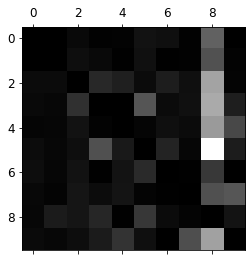

In [67]:
np.fill_diagonal(norm_conf_mx,0)#用0填充对角线，只保留错误
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

例如，很多数字被错误识别为了8,3和5容易识别错误。

Saving figure error_analysis_digits_plot


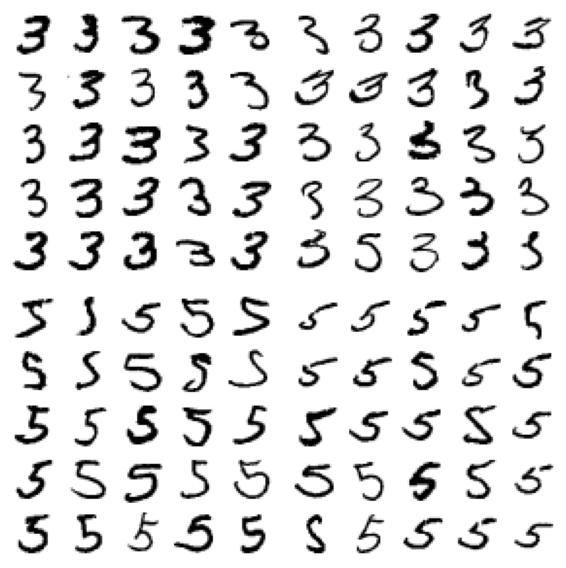

In [71]:
cl_a,cl_b = 3, 5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 6、多标签分类

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train > 7) #是否大于7
y_train_odd = (y_train % 2 == 1)#是否是奇数
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])#第一张图片

array([[False,  True]])

评估多标签分类，测量每个标签F1分数，简单求平均值或加权；
若使用权重，则将average设置为‘weighted’即可

In [75]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')#标签权值平均

0.9705516699095764

# 7、多输出分类

多输出-多类分类,例如，输入一张有噪声的图片，输出干净的图片

In [77]:
noise = np.random.randint(0,100,(len(X_train),784))#随机数噪声
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


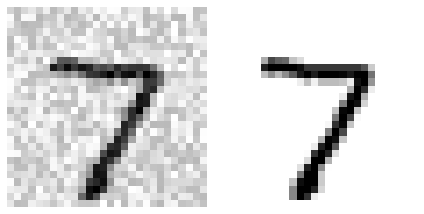

In [82]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

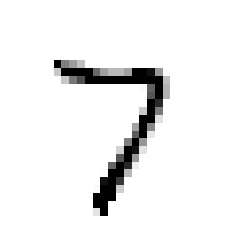

In [85]:
# some_index = X[2]
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Extra

网格搜索提高准确率

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid=[{'weights':['uniform','distance'],'n_neighbors':[3,4,5]}]
knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  33.3s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  31.7s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  32.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  36.7s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  40.3s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  31.6s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  41.7s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  41.8s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  46.6s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  43.2s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  36.1s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [93]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [94]:
grid_search.best_score_

0.9716166666666666

使用测试集，查看精确度的多少

In [100]:
from sklearn.metrics import accuracy_score
y_grid_pred = grid_search.predict(X_train)
accuracy_score(y_train, y_grid_pred)

1.0

In [105]:
from sklearn.metrics import accuracy_score
y_grid_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_grid_pred)

0.9714